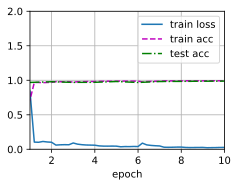

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import sys
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
from IPython import display
# Define the number of inputs, hidden units, and outputs

num_inputs, num_outputs, num_hiddens = 784, 10, 256

# Initialize weights and biases using PyTorch
# W1 = torch.randn(num_inputs, num_hiddens) * 0.01  # Normal distribution with mean=0, std=0.01
# b1 = torch.zeros(num_hiddens)

# W2 = torch.randn(num_hiddens, num_outputs) * 0.0`1  # Same for W2
# b2 = torch.zeros(num_outputs)

# batch_size = 256
# num_inputs, num_outputs, num_hiddens = 784, 10, 256
lr = 0.9

# params = [W1, b1, W2, b2]

# for param in params:
#     param.requires_grad_()

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
# def load_data_fashion_mnist(batch_size, resize=None):  #@save
#     dataset = gluon.data.vision
#     trans = [dataset.transforms.ToTensor()]
#     if resize:
#         trans.insert(0, dataset.transforms.Resize(resize))
#     trans = dataset.transforms.Compose(trans)
#     mnist_train = dataset.FashionMNIST(train=True).transform_first(trans)
#     mnist_test = dataset.FashionMNIST(train=False).transform_first(trans)
#     return (gluon.data.DataLoader(mnist_train, batch_size, shuffle=True,
#                                   num_workers=get_dataloader_workers()),
#             gluon.data.DataLoader(mnist_test, batch_size, shuffle=False,
#                                   num_workers=get_dataloader_workers()))


def load_data_fashion_mnist(batch_size, resize=None):
    # 定义数据预处理（转换）
    transform_list = [transforms.ToTensor()]
    
    if resize:
        transform_list.insert(0, transforms.Resize(resize))
    
    transform = transforms.Compose([
        transforms.ToTensor(),  # 把图像转为张量，值范围从 [0, 255] 变为 [0, 1]
        transforms.Normalize((0.5,), (0.5,))  # 标准化到 [-1, 1]
    ])

    # 下载并加载训练集和测试集
   # 加载训练集
    train_dataset = datasets.MNIST(
        root='./data',  # 数据保存路径
        train=True,     # True 表示训练集
        transform=transform,
        download=True   # 如果本地没有数据，自动下载
    )

    # 加载测试集
    test_dataset = datasets.MNIST(
        root='./data',
        train=False,    # False 表示测试集
        transform=transform,
        download=True
    )
    # 创建 DataLoader
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True  # 打乱数据
    )

    # 测试集 DataLoader
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False  # 测试时通常不打乱
    )
    return train_loader, test_loader


def get_dataloader_workers():  #@save
    return 10

# train_iter, test_iter = load_data_fashion_mnist(batch_size)

def accuracy(y_hat, y):
    _, preds = torch.max(y_hat, 1)  # Get predicted class indices
    return (preds == y).sum().item()  # Return the correct number of predictions as a scalar (float)

# #@save
# class Accumulator: 
#     """在n个变量上累加"""
#     def __init__(self, n):
#         self.data = [0.0] * n

#     def add(self, *args):
#         self.data = [a + float(b) for a, b in zip(self.data, args)]

#     def reset(self):
#         self.data = [0.0] * len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx]
    
# # 用来跟踪训练过程中的指标（损失、准确度等）
# class Accumulator:
#     def __init__(self, n):
#         self.data = [0.0] * n
    
#     def add(self, *args):
#         for i, arg in enumerate(args):
#             self.data[i] += arg
    
#     def __getitem__(self, idx):
#         return self.data[idx]
    
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n  # Initialize with 0.0 (floats)
    
    def add(self, *args):
        # Ensure that the inputs are valid numeric values (float or int)
        for i, arg in enumerate(args):
            if isinstance(arg, (int, float)):
                self.data[i] += arg  # Add the numeric value
            else:
                raise ValueError(f"Expected numeric value, got {type(arg)}")
    
    def __getitem__(self, idx):
        return self.data[idx]



# #@save
# def train_epoch(net, train_iter, loss, updater):  
#     metric = Accumulator(3)# 训练损失总和、训练准确度总和、样本数
#     if isinstance(updater, gluon.Trainer):
#         updater = updater.step
#     for X, y in train_iter:
#         # 计算梯度并更新参数
#         with autograd.record():
#             y_hat = net(X)
#             l = loss(y_hat, y)
#         l.backward()
#         updater(X.shape[0])
#         metric.add(float(l.sum()), accuracy(y_hat, y), y.shape[0])# 返回训练损失和训练精度
#     return metric[0] / metric[2], metric[1] / metric[2]

#@save
class Animator:  
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda:  set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
        
# def accuracy(y_hat, y):  #@save
#     """计算预测正确的数量"""
#     if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
#         y_hat = y_hat.argmax(axis=1)
#     cmp = y_hat.astype(y.dtype) == y
#     return float(cmp.astype(y.dtype).sum())

def use_svg_display():  #@save
    """使用svg格式在Jupyter中显示绘图"""
    backend_inline.set_matplotlib_formats('svg')
    
# def evaluate_accuracy(net, data_iter):  #@save
#     """计算在指定数据集上模型的精度"""
#     metric = Accumulator(2)  # 正确预测数、预测总数
#     for X, y in data_iter:
#         metric.add(accuracy(net(X), y),  y.size)
#     return metric[0] / metric[1]

# 测试模型的准确度
def evaluate_accuracy(net, data_iter, device):
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    metric = Accumulator(2)  # 正确预测数、预测总数
#     net.eval()  # 设置为评估模式
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y.to(device)
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]
    
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
#     text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
#                    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    text_labels = ['0', '1', '2', '3', '4','5', '6', '7', '8', '9']
    return [text_labels[int(i)] for i in labels]

# def relu(X):
#     return np.maximum(X, 0)
# in_channels（输入通道数）
# 表示输入数据的通道数。例如，对于 RGB 图像，in_channels=3（红、绿、蓝三个通道）；对于灰度图像，in_channels=1。
# 类型：整数。
# out_channels（输出通道数）
# 表示卷积操作后输出的通道数，也就是卷积核的个数。每个卷积核生成一个输出特征图。
# 类型：整数。
# kernel_size（卷积核大小）
# 定义卷积核的尺寸，可以是整数（如 3 表示 3x3）或元组（如 (3, 5) 表示 3x5）。
# 常见的卷积核大小有 3x3、5x5 等。
# stride（步幅，默认为 1）
# 控制卷积核滑动的步长。步幅越大，输出尺寸越小。
# 类型：整数或元组。
# padding（填充，默认为 0）
# 在输入边缘填充的像素数，用于控制输出尺寸。如果 padding=0，边缘信息可能丢失；适当填充可以保持输出尺寸。
# 类型：整数或元组。
# dilation（膨胀系数，默认为 1）
# 控制卷积核中元素之间的间距，用于 dilated convolution（空洞卷积）。默认值为 1 表示普通卷积。
# 类型：整数或元组。
# groups（分组卷积，默认为 1）
# 将输入和输出通道分成几组，分别进行卷积。默认值为 1 表示标准卷积；若设为 in_channels，则变为深度卷积（Depthwise Convolution）。
# 类型：整数。
# bias（偏置，默认为 True）
# 是否为输出添加偏置项。通常保持默认即可。
# 假设有一个简单的 CNN 模型
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),  
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5),  
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
     
    
    def forward(self, x):
        x = self.conv1(x)  # (1, 28, 28) -> (6, 14, 14)
        x = self.conv2(x)  # (6, 14, 14) -> (16, 5, 5)
        x = torch.flatten(x, start_dim=1)  # (batch_size, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # 输出 logits
        return x

# def net(X):
#     X = X.reshape((-1, num_inputs))
#     H = relu(np.dot(X, W1) + b1)
#     return np.dot(H, W2) + b2


# def updater(batch_size):
#     return sgd(params, lr, batch_size)

# def sgd(params, lr, batch_size):  # @save
#     """小批量随机梯度下降"""
#     '''
#     在机器学习中，.sgd 函数通常指的是随机梯度下降（Stochastic Gradient Descent）的缩写，它是一种用于优化模型参数的算法。
#     随机梯度下降是梯度下降算法的一种变体，用于在大规模数据集上训练模型时减少计算成本。
#     '''
#     for param in params:
#         param[:] = param - lr * param.grad / batch_size
        
# loss = gluon.loss.SoftmaxCrossEntropyLoss()


def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

# def train(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
#     """训练模型（定义见第3章）"""
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     net = SimpleCNN().to(device)
#     loss_fn = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(net.parameters(), lr=0.01)
#     animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.2, 0.9],
#                         legend=['train loss', 'train acc', 'test acc'])
#     for epoch in range(num_epochs):
#         train_metrics = train_epoch(net, train_iter, loss_fn, optimizer, device)
#         test_acc = evaluate_accuracy(net, test_iter)
#         animator.add(epoch + 1, train_metrics + (test_acc,))
#     train_loss, train_acc = train_metrics
# num_epochs, lr = 10, 0.1
def train_epoch(net, train_iter, loss_fn, optimizer, device, animator):
    metric = Accumulator(3)  # Track loss, accuracy, and sample count
    net.train()
    num_batches = len(train_iter)
    for i, (X, y) in enumerate(train_iter):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        # Forward pass
        y_hat = net(X)

        # Calculate loss
        loss = loss_fn(y_hat, y)

        # Backpropagation and optimizer step
        loss.backward()
        optimizer.step()
        with torch.no_grad():
#             metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
        # Update metrics (make sure accuracy returns a numeric value)
            metric.add(loss.item() * X.shape[0], accuracy(y_hat, y), X.shape[0])
     
    return metric[0] / metric[2], metric[1] / metric[2] 


def train(net, train_iter, test_iter, loss, num_epochs, lr, device):
    optimizer = optim.SGD(net.parameters(), lr=lr)
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.0, 2],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
#         train_metrics = train_epoch(net, train_iter, loss, optimizer, device, animator)
        metric = Accumulator(3)  # Track loss, accuracy, and sample count
        net.train()
        num_batches = len(train_iter)
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()

            # Forward pass
            y_hat = net(X)

            # Calculate loss
            loss = loss_fn(y_hat, y)

            # Backpropagation and optimizer step
            loss.backward()
            optimizer.step()
            with torch.no_grad():
#             metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
        # Update metrics (make sure accuracy returns a numeric value)
                metric.add(loss.item() * X.shape[0], accuracy(y_hat, y), X.shape[0])
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy(net, test_iter, device)
        animator.add(epoch + 1, (None, None, test_acc))
#         animator.add(epoch + 1, metric[0] / metric[2], metric[1] / metric[2] + (test_acc,))
    return metric[0] / metric[2], metric[1] / metric[2] 

# 数据加载
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# 模型、损失函数和优化器
net = LeNet().to(device)
loss_fn = nn.CrossEntropyLoss()
train_loss, train_acc = train(net, train_iter, test_iter, loss_fn, num_epochs=10, lr=0.9, device=device)

def predict(net, test_iter, n=100):  #@save
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict(net, test_iter)